In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import re

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

## Первичные экпериментальные данные

In [4]:
data = mipt.read_excel('data/5.1.2.xlsx', usecols=('A', 'B', 'C'), header=(0)).dropna()
data


# Ширина по половине высоты. Я у него спрашивал на лабе.
fmt = {
    ('Theta') : [r'$\theta, ^\circ$', '{:.0f}', 0],
    ('N') : [r'$N$, кан.', '{:.0f}', 0],
    ('Width') : [r'$\Delta N$, кан.', '{:.0f}', 0],
}

tab = mipt.table(data, fmt)
tab.to_latex('gen/tab-data.tex')

dT = 1
dTheta = np.empty(len(data['N']))
dTheta.fill(dT) 

data.insert(1, 'dTheta', dTheta)

dN = np.empty(len(data['N']))
dN.fill(5) 

data.insert(3, 'dN', dN)

data

,Theta,dTheta,N,dN,Width
0,0,1.0,923,5.0,89
1,10,1.0,812,5.0,79
2,20,1.0,778,5.0,95
3,30,1.0,790,5.0,91
4,40,1.0,743,5.0,89
5,50,1.0,614,5.0,83
6,60,1.0,558,5.0,82
7,70,1.0,482,5.0,78
8,80,1.0,431,5.0,65
9,90,1.0,400,5.0,56


N( 0) = 875.5168948786476 +- 18.65285796309314, eps=2.130496632583949%
N(90) = 396.857006301796 +- 6.072621224045716, eps=1.530178660730938%
mc2 = 548.864328182803 +- 26.333665948588447 кэВ, eps=4.797846133629191%


/tmp/ipykernel_115305/2163291887.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  N_0 = float(1 / mnk['b'])
/tmp/ipykernel_115305/2163291887.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dN_0 = float(mnk['db'] / mnk['b'] * N_0)
/tmp/ipykernel_115305/2163291887.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  N_90 = 1 / float(mnk['b'] + mnk['a'] * 1)
/tmp/ipykernel_115305/2163291887.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dN_90 = float(math.sqrt(mnk['db']**2 + mnk['da']**2)) / float(mnk['b'] + mnk['a'] * 1) * N_90


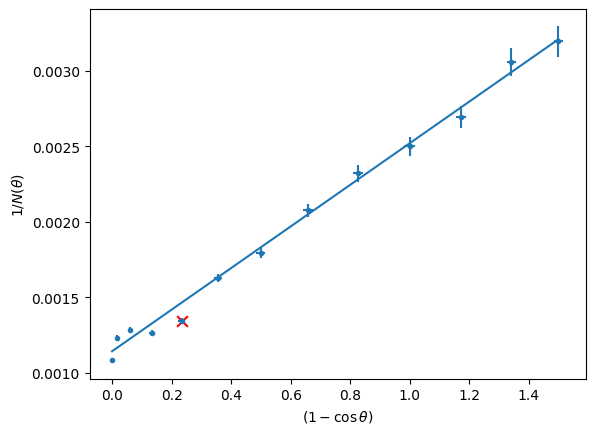

In [8]:
x = 1 - np.cos(data['Theta'] * math.pi / 180)
y = 1 / data['N']

y_err = 10 / data['N'] * y # y #* 0. data['Width'] / data['N']

x_err = np.abs(np.sin(data['Theta'] * math.pi / 180) * data['dTheta'] * math.pi / 180)

xc, yc, equ = mipt.plot(x, y, yerr = y_err, xerr = x_err, exclude=(4,))
mnk = mipt.mnk(xc, yc).data
plt.xlabel(r"$(1 - \cos \theta)$")
plt.ylabel(r"$1/N(\theta)$")
plt.savefig("gen/plot1.png")

N_0 = float(1 / mnk['b'])
dN_0 = float(mnk['db'] / mnk['b'] * N_0)

N_90 = 1 / float(mnk['b'] + mnk['a'] * 1)
dN_90 = float(math.sqrt(mnk['db']**2 + mnk['da']**2)) / float(mnk['b'] + mnk['a'] * 1) * N_90 


print("N( 0) = {} +- {}, eps={}%".format(N_0, dN_0, dN_0/N_0 * 100))
print("N(90) = {} +- {}, eps={}%".format(N_90, dN_90, dN_90/N_90 * 100))

Ey = 662 # кэВ (стр. 27)
mc2 = Ey * N_90 / (N_0 - N_90)


dmc2 = Ey * math.sqrt( dN_90**2 * ( (1/(N_0-N_90)) + (N_90/(N_0-N_90)**2) )**2 + dN_0**2 * (N_90/(N_0-N_90)**2)**2 )
print("mc2 = {} +- {} кэВ, eps={}%".format(mc2, dmc2, dmc2/mc2 * 100))